In [4]:
%matplotlib inline

## Cats vs Dogs redux

Attempting to configure files etc:

> NOTE: You will need to first set up these dependencies: 
- install the kaggle cli with: `pip install kaggle-cli`
- then set kaggle username and password with `kg config -u <username> -p <password>` (see https://github.com/floydwch/kaggle-cli for details). You will also need to have gone to kaggle and accepted the terms for this challenge before you can download the data.`
- apt-get install unzip

Downloading the data

In [2]:
!kg download -c dogs-vs-cats-redux-kernels-edition

Starting new HTTPS connection (1): www.kaggle.com
downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/test.zip

Starting new HTTPS connection (1): storage.googleapis.com
test.zip 100% |######################################| Time: 0:00:08  32.9 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/train.zip

train.zip 100% |#####################################| Time: 0:00:16  33.7 MiB/s

downloading https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/download/sample_submission.csv

sample_submission.csv 100% |#########################| Time: 0:00:00 357.0 KiB/s



Moving the data into the proper directory

In [3]:
%%bash
mkdir -p data/catsdogs
mv sample_submission.csv data/catsdogs
mv test.zip data/catsdogs
mv train.zip data/catsdogs
cd data/catsdogs
unzip -q ./test.zip
unzip -q ./train.zip

Formatting the file structure

In [5]:
%%bash
function mv_n_files { # amount, srcDir, targetDir
    for file in $(ls -p $2 | grep -v / | tail -$1)
    do
    mv $2/$file $3
    done
}

function cp_n_files { # amount, srcDir, targetDir
    for file in $(ls -p $2 | grep -v / | tail -$1)
    do
    cp $2/$file $3
    done
}

# # Split train into cat and dog directories
cd data/catsdogs
mkdir -p train/cat
mkdir -p train/dog
cd train
for x in *; do
  case "$x" in
    cat.*) 
       mv -- "$x" cat/
       ;;
  esac
done
for x in *; do 
  case "$x" in 
    dog.*) 
      mv -- "$x" dog/ 
      ;; 
    esac
done
cd -
# mv train/cat.* train/cat
# mv train/dog.* train/dog
mkdir -p test/unknown
cd test
mv *.jpg unknown
cd -

# Create validation set
mkdir -p valid/cat
mkdir -p valid/dog
mv_n_files 1000 train/cat valid/cat
mv_n_files 1000 train/dog valid/dog

# Create sample working directory
mkdir -p sample/train/cat
mkdir -p sample/train/dog
mkdir -p sample/valid/cat
mkdir -p sample/valid/dog
mkdir -p sample/test/unknown
sample_size=100
cp_n_files $sample_size train/cat sample/train/cat
cp_n_files $sample_size train/dog sample/train/dog
cp_n_files $sample_size valid/cat sample/valid/cat
cp_n_files $sample_size valid/dog sample/valid/dog
cp_n_files $sample_size test/unknown sample/test/unknown


Set up sample directory

Setting up the data path:

In [2]:
# path = "data/catsdogs/sample/"
path = "data/catsdogs/"

## Creating the VGG classifier

In [5]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

In [6]:
# Add to python path dynamically
import sys
sys.path.insert(0, '../../deeplearning1/nbs')

In [7]:
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [8]:
batch_size = 64

In [9]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [28]:
vgg = Vgg16()
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=1)

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/1
23000/23000 [==============================] - 655s - loss: 0.1152 - acc: 0.9690 - val_loss: 0.0589 - val_acc: 0.9810


In [29]:
vgg.model.save_weights(path+'results/ft1.h5')

In [12]:
vgg = Vgg16()
vgg.model.load_weights(path+'results/ft1.h5')

## Output predictions to submit
Run predictions on test results

In [30]:
test_batches = vgg.get_batches(path+'test', batch_size=5, class_mode=None)

Found 12500 images belonging to 1 classes.


In [31]:
test_imgs = next(test_batches)

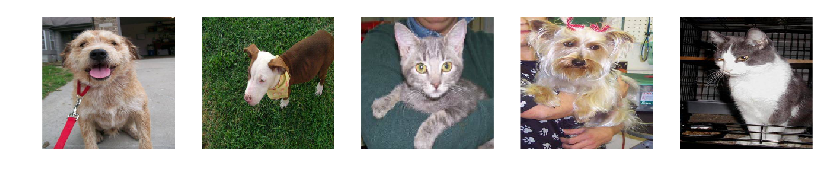

In [32]:
plots(test_imgs[:5])

In [33]:
vgg.predict(test_imgs)

(array([ 1.    ,  0.9997,  1.    ,  0.9992,  1.    ], dtype=float32),
 array([1, 1, 0, 1, 0]),
 ['dog', 'dog', 'cat', 'dog', 'cat'])

In [25]:
batches, preds = vgg.test(path+'test')

Found 12500 images belonging to 1 classes.


In [27]:
filenames = batches.filenames
batches.filenames[:5]

['unknown/9292.jpg',
 'unknown/12026.jpg',
 'unknown/9688.jpg',
 'unknown/4392.jpg',
 'unknown/779.jpg']

Save data for later

In [26]:
results_path = 'saved_catsdogs_data/'

In [30]:
from utils import save_array
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'test_filenames.dat', filenames)

In [36]:
is_dog = preds[:, 1]
is_dog[:5]

array([  1.4314e-09,   4.4904e-02,   9.4252e-07,   3.4537e-12,   1.0000e+00], dtype=float32)

In [34]:
file_ids = [int(f[8:f.find('.')]) for f in filenames]
file_ids[:5]

[9292, 12026, 9688, 4392, 779]

In [35]:
submit_data = np.stack([file_ids, is_dog], axis=1)
submit_data[:5]

array([[  9.2920e+03,   5.0000e-02],
       [  1.2026e+04,   5.0000e-02],
       [  9.6880e+03,   5.0000e-02],
       [  4.3920e+03,   5.0000e-02],
       [  7.7900e+02,   9.5000e-01]])

In [36]:
np.savetxt(results_path+'submission.csv', submit_data, fmt='%d, %0.5f', header='id,label', comments='')

## Improve submission

In [21]:
# saved_csv = np.loadtxt('saved_catsdogs_data/submission.csv', skiprows=1, delimiter=',', unpack=True)
# saved_csv[:5]

array([[  9.2920e+03,   1.2026e+04,   9.6880e+03, ...,   1.1708e+04,   5.2500e+02,   6.3750e+03],
       [  0.0000e+00,   4.4900e-02,   0.0000e+00, ...,   0.0000e+00,   0.0000e+00,   9.9999e-01]])

In [33]:
is_dog = preds[:, 1].clip(min=0.05, max=0.95)
is_dog[:5]

array([ 0.05,  0.05,  0.05,  0.05,  0.95], dtype=float32)